This file contains the model architecture that combines BERT with BiLSTM to then predict the labels.

In [21]:
# choose dataset from 'NPOV', 'WNC', 'CrowS-Pairs', 'Stereo', 'Mixed'
dataset = 'Mixed'

# Setting Up

In [22]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import seaborn as sns
import shutil
import nltk
import sys
import matplotlib.pyplot as plt
from string import punctuation
from transformers import BertTokenizerFast, BertModel 
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [24]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [25]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Model checkpoint

In [26]:
# Save and Load Functions

def save_checkpoint(save_path, model, optimizer, valid_loss):

    if save_path == None:
        return
    
    state_dict = {'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'valid_loss': valid_loss}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_checkpoint(load_path, model, optimizer):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    model.load_state_dict(state_dict['model_state_dict'])
    optimizer.load_state_dict(state_dict['optimizer_state_dict'])
    
    return state_dict['valid_loss']

# Data

In [27]:
# import datasets
source_folder = "/content/drive/MyDrive/Colab Notebooks/Amplifi Project/Data/Processed Datasets/"
train_df = pd.read_csv(source_folder + dataset + '_train.csv', delimiter=',')
val_df = pd.read_csv(source_folder + dataset + '_valid.csv', delimiter=',')
test_df = pd.read_csv(source_folder + dataset + '_test.csv', delimiter=',')

In [28]:
target_list = ['label']

In [29]:
# hyperparameters
max_len = 200
train_batch_size = 16
val_batch_size = 16
test_batch_size = 16

In [30]:
class CustomDataset(torch.utils.data.Dataset):

    def __init__(self, df, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.df = df
        self.title = df['text']
        self.targets = self.df[target_list].values
        self.max_len = max_len

    def __len__(self):
        return len(self.title)

    def __getitem__(self, index):
        title = str(self.title[index])
        title = " ".join(title.split())

        inputs = self.tokenizer.encode_plus(
            title,
            None,
            add_special_tokens=False,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': inputs['input_ids'].flatten(), # ID of each token in the text
            'attention_mask': inputs['attention_mask'].flatten(),
            'token_type_ids': inputs["token_type_ids"].flatten(),
            'targets': torch.FloatTensor(self.targets[index]).squeeze() # Bias (1) and Unbias (0) label --> 1 dimensional: (batch_size,)
        }

In [31]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

In [32]:
train_dataset = CustomDataset(train_df, tokenizer, max_len)
val_dataset = CustomDataset(val_df, tokenizer, max_len)
test_dataset = CustomDataset(test_df, tokenizer, max_len)

In [33]:
train_loader = torch.utils.data.DataLoader(train_dataset, 
    batch_size=train_batch_size,
    shuffle=True,
    num_workers=0
)

val_loader = torch.utils.data.DataLoader(val_dataset, 
    batch_size=val_batch_size,
    shuffle=True,
    num_workers=0
)

test_loader = torch.utils.data.DataLoader(test_dataset, 
    batch_size=test_batch_size,
    shuffle=True,
    num_workers=0
)

# Model

In [34]:
class Mixed_Model_1(nn.Module):
    def __init__(self):
          super(Mixed_Model_1, self).__init__()
          self.bert = BertModel.from_pretrained("bert-base-uncased", return_dict=True)
          ### New layers:
          self.lstm = nn.LSTM(768, 256, batch_first=True,bidirectional=True)
          self.linear = nn.Linear(256*2, 1)
          

    def forward(self, input_ids, attn_mask):
          bert_output = self.bert(
          input_ids, 
          attention_mask=attn_mask
          ) 

          # print(bert_output.last_hidden_state.shape)

          # sequence_output has the following shape: (batch_size, sequence_length, 768)
          lstm_output, (h,c) = self.lstm(bert_output.last_hidden_state) ## extract the 1st token's embeddings
          hidden = torch.cat((lstm_output[:,-1, :256],lstm_output[:,0, 256:]),dim=-1)
          linear_output = self.linear(hidden.view(-1,256*2)) ### assuming that you are only using the output of the last LSTM cell to perform classification

          return torch.squeeze(linear_output, 1)

# Initialise model

In [35]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

In [36]:
model = Mixed_Model_1()
model.to(device)
optimizer = torch.optim.Adam(params =  model.parameters(), lr=1e-5)

destination_folder = "/content/drive/MyDrive/Colab Notebooks/Amplifi Project/Saved Models and Checkpoints"

try:
  load_checkpoint(destination_folder + '/mixed_model_1_' + dataset + '.pt', model, optimizer) # comment this if you wannt to trainn the model from zero
  print('mixed_model_1_' + dataset + '.pt --> loaded')
except:
  print('training mixed_model_1_' + dataset + ' from scratch')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


training mixed_model_1_Mixed from scratch


# Training

In [37]:
val_targets=[]
val_outputs=[]

In [38]:
def train_model(n_epochs, training_loader, validation_loader, model, 
                optimizer, destination_folder):
   
  # initialize tracker for minimum validation loss
  best_valid_loss = np.Inf
  # best_valid_loss = 0.546463
  
  try:
    best_valid_loss
  except:
    best_valid_loss = np.Inf
   
 
  for epoch in range(1, n_epochs+1):
    train_loss = 0
    valid_loss = 0

    model.train()
    print('############# Epoch {}: Training Start   #############'.format(epoch))
    for batch_idx, data in enumerate(training_loader):

        if batch_idx % round(len(training_loader)/6) == 0:
          print(f'--> epoch: {epoch}/{n_epochs} --- step {batch_idx}/{len(training_loader)}')

        ids = data['input_ids'].to(device, dtype = torch.long)
        mask = data['attention_mask'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        outputs = model(ids, mask)

        optimizer.zero_grad()
        loss = loss_fn(outputs, targets)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.item() - train_loss))
        train_loss += loss.item()
    
    print('############# Epoch {}: Training End     #############'.format(epoch))

    print('############# Epoch {}: Validation Start   #############'.format(epoch))
    ######################    
    # validate the model #
    ######################
 
    model.eval()
   
    with torch.no_grad():
      for batch_idx, data in enumerate(validation_loader, 0):
            if batch_idx % round(len(validation_loader)/6) == 0:
              print(f'--> epoch: {epoch}/{n_epochs} --- step {batch_idx}/{len(validation_loader)}')
            
            ids = data['input_ids'].to(device, dtype = torch.long)
            mask = data['attention_mask'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask)

            loss = loss_fn(outputs, targets)
            # valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.item() - valid_loss))
            valid_loss += loss.item()
            val_targets.extend(targets.cpu().detach().numpy().tolist())
            val_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())

      print('############# Epoch {}: Validation End     #############'.format(epoch))
      # calculate average losses
      #print('before cal avg train loss', train_loss)
      train_loss = train_loss/len(training_loader)
      valid_loss = valid_loss/len(validation_loader)
      # print training/validation statistics 
      print('Epoch: {} \tAvgerage Training Loss: {:.6f} \tAverage Validation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
      ## TODO: save the model if validation loss has decreased
      if valid_loss <= best_valid_loss:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(best_valid_loss,valid_loss))
        # save checkpoint as best model
        save_checkpoint(destination_folder + '/mixed_model_1_' + dataset + '.pt', model, optimizer, best_valid_loss)
        best_valid_loss = valid_loss

    print('############# Epoch {}  Done   #############\n'.format(epoch))

  return model

## Storage of training and validation losses:
- epoch 1: T = 0.579432 | V = 0.554498
- epoch 2: T = 0.533245 | V = 0.546463
- epoch 3: T = 0.490669 | V = 0.565605

In [39]:
epochs = 5
trained_model = train_model(epochs, train_loader, val_loader, model, optimizer, destination_folder)

############# Epoch 1: Training Start   #############
--> epoch: 1/5 --- step 0/500
--> epoch: 1/5 --- step 83/500
--> epoch: 1/5 --- step 166/500
--> epoch: 1/5 --- step 249/500
--> epoch: 1/5 --- step 332/500
--> epoch: 1/5 --- step 415/500
--> epoch: 1/5 --- step 498/500
############# Epoch 1: Training End     #############
############# Epoch 1: Validation Start   #############
--> epoch: 1/5 --- step 0/63
--> epoch: 1/5 --- step 10/63
--> epoch: 1/5 --- step 20/63
--> epoch: 1/5 --- step 30/63
--> epoch: 1/5 --- step 40/63
--> epoch: 1/5 --- step 50/63
--> epoch: 1/5 --- step 60/63
############# Epoch 1: Validation End     #############
Epoch: 1 	Avgerage Training Loss: 0.648522 	Average Validation Loss: 0.637027
Validation loss decreased (inf --> 0.637027).  Saving model ...
Model saved to ==> /content/drive/MyDrive/Colab Notebooks/Amplifi Project/Saved Models and Checkpoints/mixed_model_1_Mixed.pt
############# Epoch 1  Done   #############

############# Epoch 2: Training Start

# Testing

In [ ]:
# testing
corrects = 0
totals = 0

test_model = Mixed_Model_1()
test_model.to(device)
# optimizer = torch.optim.Adam([
#                 {'params': test_model.bert.parameters()},
#                 {'params': test_model.bilstm.parameters(), 'lr': 0.001}
#             ], lr=1e-5)
optimizer = torch.optim.Adam(params =  test_model.parameters(), lr=1e-5)
destination_folder = "/content/drive/MyDrive/Colab Notebooks/Amplifi Project/Saved Models and Checkpoints/"
load_checkpoint(destination_folder + '/mixed_model_1_' + dataset + '.pt', test_model, optimizer)

with torch.no_grad():
  test_model.eval() 
  for batch_idx, data in enumerate(test_loader, 0): 
    input_ids = data['input_ids'].to(device, dtype=torch.long)
    attention_mask = data['attention_mask'].to(device, dtype=torch.long)
    output = test_model(input_ids, attention_mask)
    final_output = torch.sigmoid(output).cpu().detach().numpy().tolist()
    pred_class = np.round(final_output)
    corrects += np.count_nonzero((data['targets'] - pred_class) == 0.)
    totals += len(pred_class)
  
  # Calculate accuracy of test set
  acc = corrects / totals

  print(f'accuracy = {acc * 100} %')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model loaded from <== /content/drive/MyDrive/Colab Notebooks/Amplifi Project/Saved Models and Checkpoints/mixed_model_1.pt
accuracy = 71.35654857016915 %


# Evaluation

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model loaded from <== /content/drive/MyDrive/Colab Notebooks/Amplifi Project/Saved Models and Checkpoints/mixed_model_1_Mixed.pt
Classification Report:
remember: 1 = BIASED, 0 = UNBIASED
              precision    recall  f1-score   support

           1     0.7619    0.6095    0.6772       525
           0     0.6466    0.7895    0.7109       475

    accuracy                         0.6950      1000
   macro avg     0.7042    0.6995    0.6941      1000
weighted avg     0.7071    0.6950    0.6932      1000



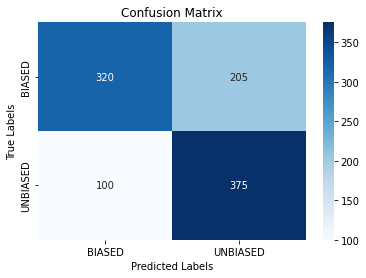

In [40]:
# Evaluation Function

def evaluate(model, test_loader, threshold=0.5):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for data in test_loader:           
            labels = data['targets'].to(device)
            input_ids = data['input_ids'].to(device, dtype=torch.long)
            attention_mask = data['attention_mask'].to(device, dtype=torch.long)
            output = model(input_ids, attention_mask)
            output = torch.sigmoid(output).cpu().detach().numpy().tolist()
            output = np.round(output)
            y_pred.extend(output.tolist())
            y_true.extend(labels.tolist())
    
    print('Classification Report:')
    print('remember: 1 = BIASED, 0 = UNBIASED')
    print(classification_report(y_true, y_pred, labels=[1,0], digits=4))
    
    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['BIASED', 'UNBIASED'])
    ax.yaxis.set_ticklabels(['BIASED', 'UNBIASED'])
    
    
best_model = Mixed_Model_1().to(device)
optimizer = optim.Adam(best_model.parameters(), lr=1e-5)

destination_folder = "/content/drive/MyDrive/Colab Notebooks/Amplifi Project/Saved Models and Checkpoints"
load_checkpoint(destination_folder + '/mixed_model_1_' + dataset + '.pt', best_model, optimizer)
evaluate(best_model, test_loader)